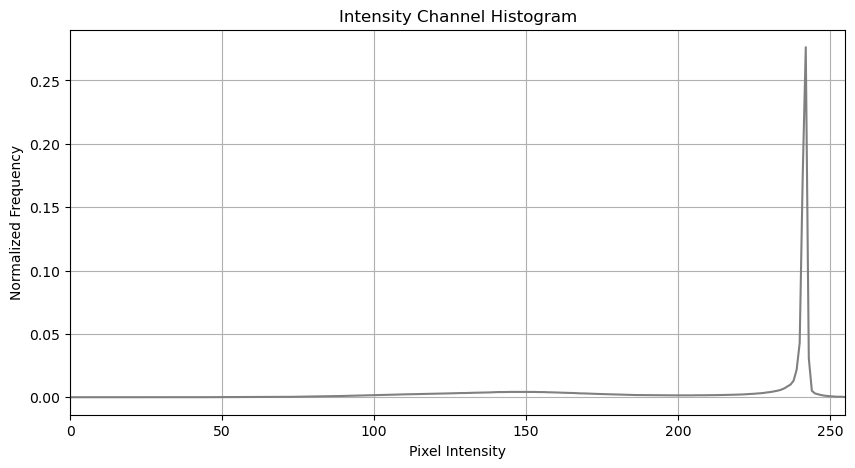

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_intensity_histogram(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert the RGB image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the histogram for the grayscale image
    hist, bins = np.histogram(gray_image.flatten(), bins=256, range=[0, 256])
    
    # Normalize the histogram
    hist = hist / hist.sum()  # Normalize to get probabilities
    
    # Plot the histogram
    plt.figure(figsize=(10, 5))
    plt.plot(hist, color='gray')
    plt.title('Intensity Channel Histogram')
    plt.xlim([0, 255])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Normalized Frequency')
    plt.grid()
    plt.show()

# Example usage
image_path = r"C:\Users\lakho\Desktop\URECA\Whole Slide Images .svs\Level 3\WSI 1_level_3.jpg"
extract_intensity_histogram(image_path)

## Interpretation:

X-Axis (Pixel Intensity Values):

Values range from 0 (black/darkest pixels) on the left to 255 (white/brightest pixels) on the right.
Y-Axis (Normalized Frequency):

Represents the proportion of pixels in the image corresponding to each intensity value. Higher values indicate that more pixels have that particular intensity.
Observations:
Peak near 255 (far right):

There is a sharp peak at the high-intensity end (close to 255), indicating that a significant portion of the image consists of bright or white pixels. This could be due to a large background area or white spaces in the image.
Low values across the rest of the range (0 to ~240):

The low frequency across most of the histogram suggests that darker intensities are much less common in the image. The image likely has very few shadows or dark regions.
Flat region (0 to ~200):

The relatively flat and near-zero values in this range indicate that pixels with medium and low intensity are not prominent.


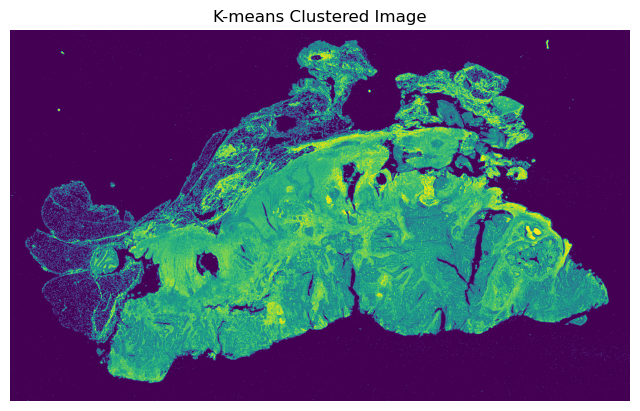

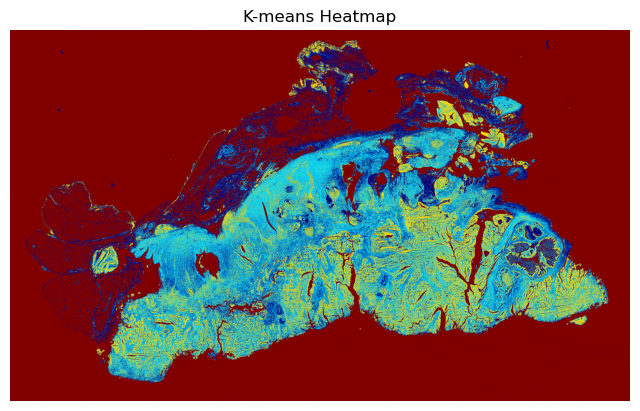

In [18]:
def apply_kmeans_clustering(wsi_path, n_clusters=4):
    """
    Applies K-means clustering on the intensity channel of a WSI image to segment tumor regions.

    Args:
        wsi_path (str): Path to the WSI JPG file.
        n_clusters (int): Number of clusters for K-means clustering.

    Returns:
        dict: Dictionary containing clustered image, colormap, heatmap, and labels.
    """
    try:
        # Load the WSI image
        image = cv2.imread(wsi_path)

        # Convert the image to grayscale to get intensity channel
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Reshape the image into a 2D array of pixels
        pixel_values = gray_image.reshape((-1, 1))
        pixel_values = np.float32(pixel_values)

        # Define criteria and apply K-means
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
        _, labels, (centers) = cv2.kmeans(pixel_values, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # Convert labels to the original image shape
        labels = labels.flatten()
        clustered_image = labels.reshape(gray_image.shape)

        # Generate colormap
        cmap = plt.cm.viridis
        normalized_image = (clustered_image - clustered_image.min()) / (clustered_image.max() - clustered_image.min())
        colormap_image = cmap(normalized_image)

        # Generate heatmap
        heatmap = (normalized_image * 255).astype(np.uint8)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Display the clustered image with labels
        plt.figure(figsize=(8, 8))
        plt.imshow(clustered_image, cmap='viridis')
        plt.title('K-means Clustered Image')
        plt.axis('off')
        plt.show()

        # Display the heatmap
        plt.figure(figsize=(8, 8))
        plt.imshow(heatmap)
        plt.title('K-means Heatmap')
        plt.axis('off')
        plt.show()

        return {
            "clustered_image": clustered_image,
            "colormap": colormap_image,
            "heatmap": heatmap,
            "labels": labels
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

if __name__ == "__main__":
    # Example usage
    wsi_path = r"C:\Users\lakho\Desktop\URECA\Whole Slide Images .svs\Level 2\WSI 1_level_2.jpg"
    result = apply_kmeans_clustering(wsi_path)
    if result:
        clustered_image = result["clustered_image"]
        colormap = result["colormap"]
        heatmap = result["heatmap"]
        labels = result["labels"]

In [22]:
def refine_with_hdbscan(kmeans_result, min_cluster_size=50, min_samples=5):
    """
    Refines K-means clustering results using HDBSCAN for better separation of tumor regions.

    Args:
        kmeans_result (dict): Output of K-means clustering containing pixel values and clustered image.
        min_cluster_size (int): Minimum size of clusters for HDBSCAN.
        min_samples (int): Minimum samples for core points in HDBSCAN.

    Returns:
        np.ndarray: Refined clustered image.
    """
    try:
        # Extract pixel values from the K-means result
        pixel_values = result["pixel_values"]

        # Apply HDBSCAN clustering
        hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        hdb_labels = hdbscan.fit_predict(pixel_values)

        # Reshape HDBSCAN labels back to the image shape
        refined_image = hdb_labels.reshape(result["clustered_image"].shape)

        # Map noise points (label -1) to 0 for visualization
        refined_image[refined_image == -1] = 0

        # Display the refined image
        plt.figure(figsize=(8, 8))
        plt.imshow(refined_image, cmap='viridis')
        plt.title('HDBSCAN Refined Clustered Image')
        plt.axis('off')
        plt.show()

        return refined_image

    except Exception as e:
        print(f"An error occurred during HDBSCAN refinement: {e}")
        return None

if __name__ == "__main__":
    # Example usage
    wsi_path = r"C:\Users\lakho\Desktop\URECA\Whole Slide Images .svs\Level 2\WSI 1_level_2.jpg"
    if result:
        refined_result = refine_with_hdbscan(result)

An error occurred during HDBSCAN refinement: 'pixel_values'
